# Imports

In [1]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Task 1

Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

## Solution

### Explanation and assumptions

**Explanation**

For this task, we have to retrieve the information in 2 separate steps.

The first step is to retrieve the data (name of university, rank, country and region) using a simple GET query on a file. We used the Postman extension with the interceptor in order to find this file. The file contains a list of the 1000 best ranked universities sorted by rank. This file contains data in the JSON format.

The second step is to retrieve the number of faculty members and the number of students (international and total) for each university by following the details page found in the JSON data. When reaching the details page, we can simply parse the HTML and retrieve the needed information.

**Assumptions**

Some universities do not have statistics for the number of students and the number of faculty members so we store NaN for those features.

We also store the score of the university even if not asked in order to use it in the next steps

### Data retrieving

In [2]:
# Constants

TOP_UNIVERSITIES_BASE = 'https://www.topuniversities.com'
TOP_UNIVERSITIES_RANKING = TOP_UNIVERSITIES_BASE + '/sites/default/files/qs-rankings-data/357051.txt'
column_names = ['name', 'rank', 'country', 'region', 'score']

# mapping between div class names in the HTML and the column name in the dataframe
names_map = {
    'total faculty': 'faculty_tot',
    'inter faculty': 'faculty_int',
    'total student': 'student_tot', 
    'total inter': 'student_int'
}

In [3]:
ranking = requests.get(TOP_UNIVERSITIES_RANKING)
top_200 = ranking.json()['data'][:200]

In [4]:
# Create an empty array in which we will store the different rows in order to create our DataFrame
universities_top_arr = []

# Utilitary function to get the statistics information needed in the details page
def get_details_info(div_name):
    div = soup.find('div', class_=div_name)
    if div:
        return int(div
            .find('div', class_='number')
            .text
            .replace("\n", "")
            .replace(",", "")
            .strip())
    else:
        return float('NaN')

for university in top_200:
    row = {
        'name': university['title'],
        'rank': university['rank_display'],
        'country': university['country'],
        'region': university['region'],
        'score': float(university['score'])
    }
    
    # For each university, we visit its detail page and retrieve the remanining statistics
    details_page_url = TOP_UNIVERSITIES_BASE + university['url']
    r = requests.get(details_page_url)
    soup = BeautifulSoup(r.text,'html.parser')
    
    for div_class, column_name in names_map.items():
        row[column_name] = get_details_info(div_class)
    
    universities_top_arr.append(row)
    
universities_top = pd.DataFrame(universities_top_arr, columns=column_names + list(names_map.values()))

In [5]:
universities_top.head()

,name,rank,country,region,score,faculty_tot,faculty_int,student_tot,student_int
0,Massachusetts Institute of Technology (MIT),1,United States,North America,100.0,2982.0,1679.0,11067.0,3717.0
1,Stanford University,2,United States,North America,98.7,4285.0,2042.0,15878.0,3611.0
2,Harvard University,3,United States,North America,98.4,4350.0,1311.0,22429.0,5266.0
3,California Institute of Technology (Caltech),4,United States,North America,97.7,953.0,350.0,2255.0,647.0
4,University of Cambridge,5,United Kingdom,Europe,95.6,5490.0,2278.0,18770.0,6699.0


### 1) Which are the best universities in term of

We first define a little utilitary function to plot bar plots

In [6]:
def custom_bar_plot(x, y, data, title):
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(title, fontsize=15, fontweight='bold')
    sns.barplot(x=x, y=y, data=data)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)

**(a) ratio between faculty members and students**

Here we just need to compute the ratio into a new column and sort by that column. We also drop the columns with NaN's because it means that we don't have that information

**Plotting this information in bar plots does not make sense as there are too many universities, so we decided to plot only the top 10 universities for this metric (as told by the TAs)**

We notice that the ranking of a university is not directly related to the number of staff members it has.

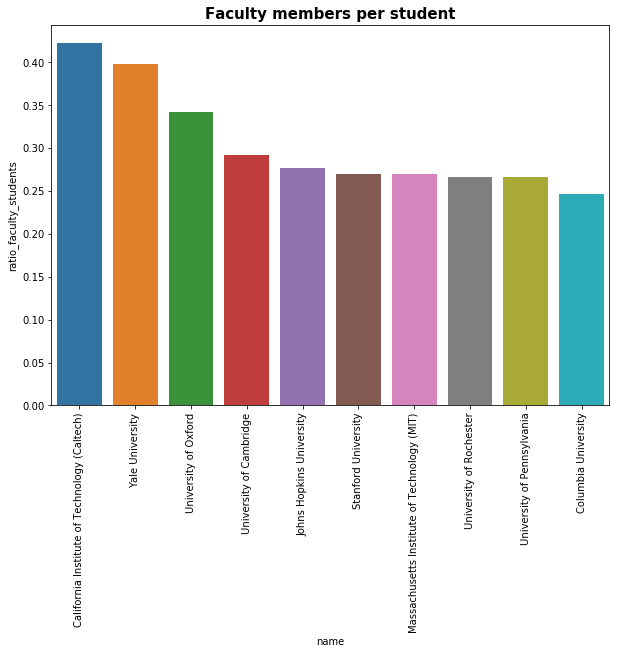

In [7]:
def ratio_faculty_students(df, columns):
    df['ratio_faculty_students'] = df['faculty_tot'] / df['student_tot']
    return df[columns].dropna()

data = ratio_faculty_students(universities_top, ['name', 'ratio_faculty_students']).sort_values('ratio_faculty_students', ascending=False)
custom_bar_plot('name', 'ratio_faculty_students', data[:10], 'Faculty members per student')

**(b) ratio of international students?**

Same here, we plot only the top 10 universities as there are too many.

We notice that London universities have many international students and that EPFL is the second one in the world! This is surprising for an engineering school as one might think that political science universities in Geneva would have more international students.

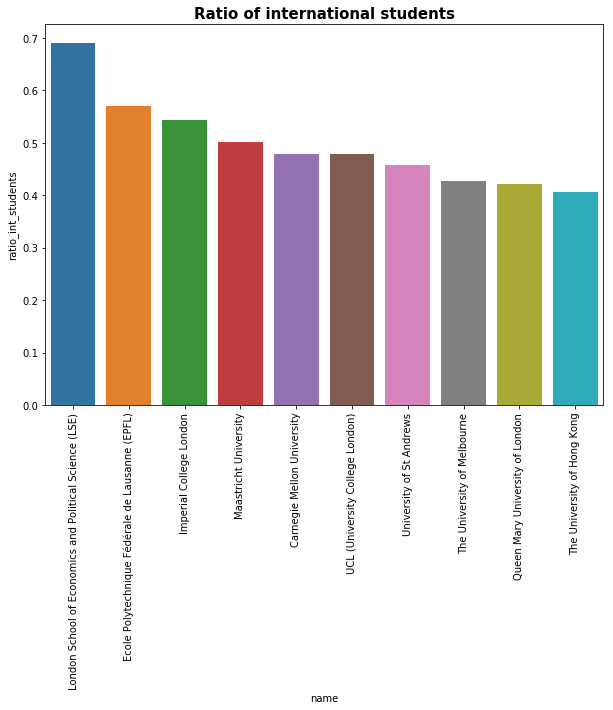

In [8]:
def ratio_int(df, columns):
    df['ratio_int_students'] = df['student_int'] / df['student_tot']
    return df[columns].dropna()

data = ratio_int(universities_top, ['name', 'ratio_int_students']).sort_values('ratio_int_students', ascending=False)
custom_bar_plot('name', 'ratio_int_students', data[:10], 'Ratio of international students')

### Answer the previous question aggregating the data by

**c) country**

Ratio of faculty members and students

In [9]:
universities_grouped_country = universities_top[['country', 'faculty_tot', 'student_tot', 'student_int']].groupby(['country'], as_index=False).sum()

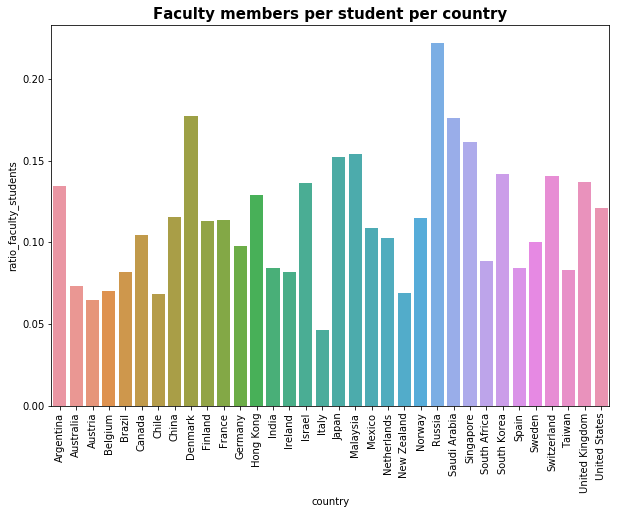

In [10]:
data = ratio_faculty_students(universities_grouped_country, ['country', 'ratio_faculty_students'])
custom_bar_plot('country', 'ratio_faculty_students', data, 'Faculty members per student per country')

The country with the most faculty members per student is Russia and the country with the less is Italy.

Ratio of international students

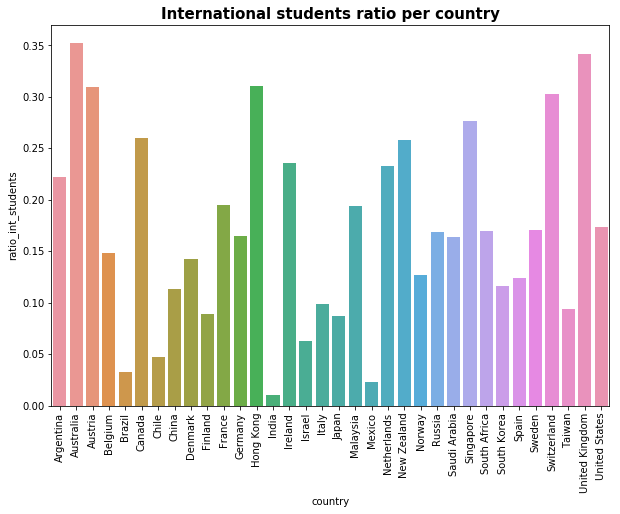

In [11]:
data = ratio_int(universities_grouped_country, ['country', 'ratio_int_students'])
custom_bar_plot('country', 'ratio_int_students', data, 'International students ratio per country')

India and Mexico have almost no international students while Australia is the country with the most.

**d) region**

Ratio of faculty members and students

In [12]:
universities_grouped_region = universities_top[['region', 'faculty_tot', 'student_tot', 'student_int']].groupby(['region'], as_index=False).sum()

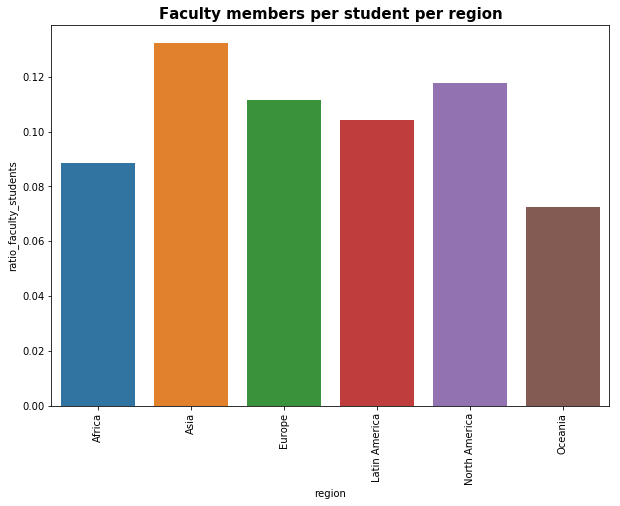

In [13]:
data = ratio_faculty_students(universities_grouped_region, ['region', 'ratio_faculty_students'])
custom_bar_plot('region', 'ratio_faculty_students', data, 'Faculty members per student per region')

As seen in the previous plot, asian universities have more staff members than other regions.

Ratio of international students

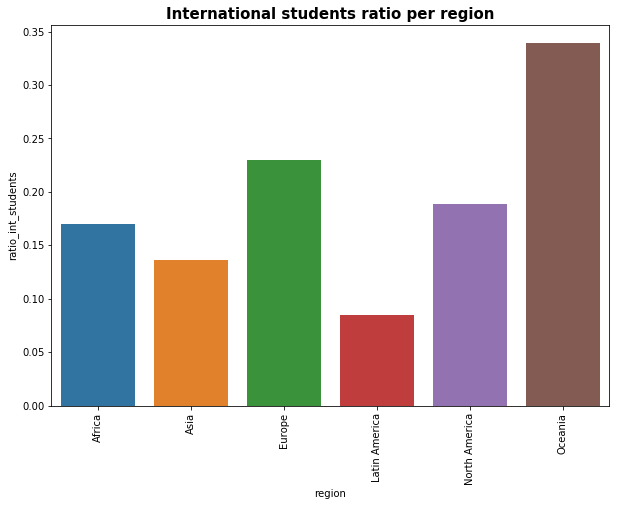

In [14]:
data = ratio_int(universities_grouped_region, ['region', 'ratio_int_students'])
custom_bar_plot('region', 'ratio_int_students', data, 'International students ratio per region')

Here we see that Oceania is the region with most international students because Australia was the country with the most international students and was one of the only countries in the top 200 being from Oceania.
So we can consider this 

## Task 2

Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018). Repeat the analysis of the previous point and discuss briefly what you observed.

## Solution

### Explanation and assumptions

**Explanation**

For this task, we can retrieve the information in one step.

We retrieve the data using a simple GET query on a file. We used the Postman extension with the interceptor in order to find the URL of this file. The file contains the list of the universities sorted by rank. This file contains data in the JSON format.

From it we parse the name of university, rank, country, score, total faculty members, total number of student and percentage of international student. 

We use the first dataframe to fetch the region of a university. After having tried it, only Luxembourg and Russia are unmatch and we decide to place them in Europe according to the first dataframe (Russia) and geograpy (Luxembourg)
We assume that the faculty members are the people who work for the students. So we retrieve the ratio of student per staff members and compute the total faculty members using this ratio and the total number of students. 

The number of international students is computed using the percentage retrieved on the website and the total number of students. 

We also ceil any value that we found since it is meaningless to have a non integer number of people.

## Code

In [15]:
# Constants
PERCENT_FORMAT = "%.1f%%"
TIMES_BASE = 'https://www.timeshighereducation.com'
TIMES_RANKING = TIMES_BASE + '/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'
column_names = ['name', 'rank', 'country', 'region', 'score']
names_map = {
    'total faculty':'faculty_tot',
    'total student':'student_tot', 
    'total inter':'student_int'
}

In [16]:
ranking = requests.get(TIMES_RANKING)
top_200 = ranking.json()['data'][:200]

In [17]:
universities_times_arr = []

# Retrieve the regions of a country from the first Dataframe
def get_region(country):
    # Get rows where country is the same and filter to have only the region
    res = universities_top[universities_top['country']==country]['region']
    
    # Check that there is a result
    if len(res):
        region = res.iloc[0]
        return region
    else:
        # Since only Russia and Luxembourg are unmatch, we decide to return Europe 
        #(luxembourg is in Europe and the first dataframe class Russia in Europe)
        print("Unmatch region for : " + country)
        return 'Europe'

def to_int(value):
    return int(value.replace(",","").replace('%',""))

for university in top_200:
    row = {
        'name': university['name'],
        'rank': university['rank'],
        'country': university['location'],
        'region' : get_region(university['location'].strip()),
        'score': float(university['scores_overall']),
        'faculty_tot': int(np.ceil(to_int(university['stats_number_students']) / float(university['stats_student_staff_ratio']))),   
        'student_tot': to_int(university['stats_number_students']),
        'student_int': int(np.ceil(to_int(university['stats_number_students']) * (to_int(university['stats_pc_intl_students']) / 100))),   
    }
    
    
    universities_times_arr.append(row)

universities_times = pd.DataFrame(universities_times_arr, columns= column_names + list(names_map.values()))

Unmatch region for : Luxembourg
Unmatch region for : Russian Federation


In [18]:
universities_times.head(10)

,name,rank,country,region,score,faculty_tot,student_tot,student_int
0,University of Oxford,1,United Kingdom,Europe,94.3,1823,20409,7756
1,University of Cambridge,2,United Kingdom,Europe,93.2,1688,18389,6437
2,California Institute of Technology,=3,United States,North America,93.0,340,2209,597
3,Stanford University,=3,United States,North America,93.0,2113,15845,3486
4,Massachusetts Institute of Technology,5,United States,North America,92.5,1285,11177,3801
5,Harvard University,6,United States,North America,91.8,2284,20326,5285
6,Princeton University,7,United States,North America,91.1,959,7955,1910
7,Imperial College London,8,United Kingdom,Europe,89.2,1391,15857,8722
8,University of Chicago,9,United States,North America,88.6,2182,13525,3382
9,ETH Zurich – Swiss Federal Institute of Techno...,=10,Switzerland,Europe,87.7,1318,19233,7309


#### a) ratio between faculty members and students

##### Explanation

We simply compute the ratio of total faculty members over the total number of students with the value we retrieved


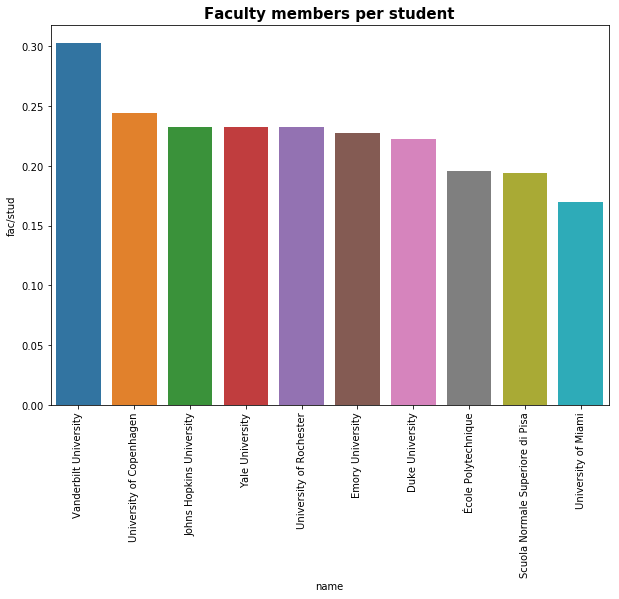

In [19]:
# Compute the ratio
universities_times['fac/stud'] = universities_times['faculty_tot'] / universities_times['student_tot']

# Convert it to float
universities_times['fac/stud'] = universities_times['fac/stud'].astype(float)

# Remove unwanted columns
fac_stud_ratio = universities_times[['name','fac/stud','country','region']]

# Sort on the ratio
fac_stud_ratio = fac_stud_ratio.sort_values(['fac/stud'],ascending=False)

show = fac_stud_ratio.copy()
custom_bar_plot('name', 'fac/stud', show[:10], 'Faculty members per student')

##### Results

Universities of the United States has 7 out of 10 places in the top 10. Vanderbilt University takes the lead of this ranking with a score of almost 20% greater than the second.

#### b) ratio of international students

##### Explanation

Same here we compute the ratio of international student over the total number of student with the value we retrieved

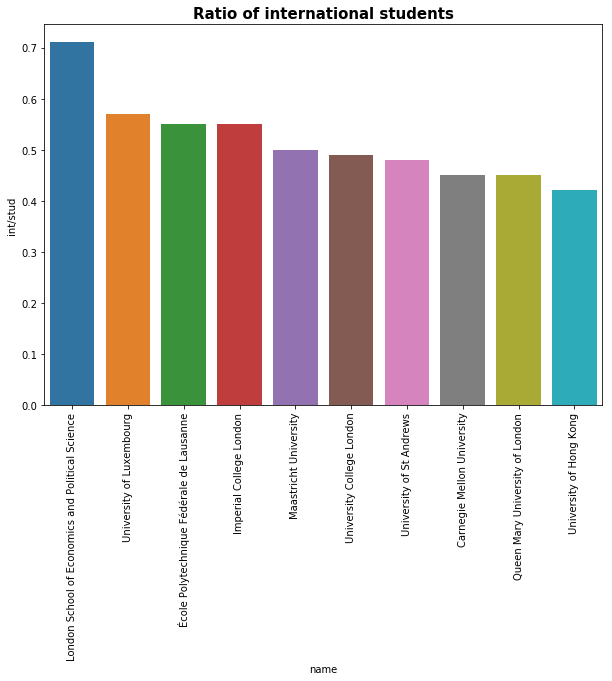

In [20]:
# Compute ratio
universities_times['int/stud'] = universities_times['student_int'] / universities_times['student_tot']

# Convert it to float
universities_times['int/stud'] = universities_times['int/stud'].astype(float)

# Remove unwanted columns
int_total_student = universities_times[['name','int/stud','country','region']]

# Sort on the ratio
int_total_student = int_total_student.sort_values(['int/stud'],ascending=False)

show = int_total_student.copy()
custom_bar_plot('name', 'int/stud', show[:10], 'Ratio of international students')

##### Results

The universities with the largest ratio of international student are the one located in Capitals and large cities. Here the United Kingdom has 5 out of 10 places in the top universities according to this ratio and London is on the firt place by far.

#### c)  
##### Explanation

To Aggregate we will first sum all the students and international students by Country and then compute the ratio. This way we will not give the same weight to smaller universities compared to larger ones.

##### 1) ratio between faculty members and students aggregated by country

In [21]:
times_uni_grouped_country = universities_times[['country', 'faculty_tot', 'student_tot', 'student_int']].groupby(['country'], as_index=False).sum()

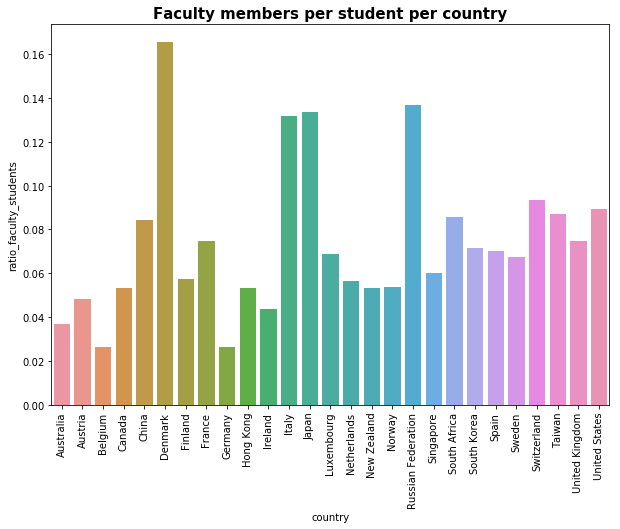

In [22]:
data = ratio_faculty_students(times_uni_grouped_country, ['country', 'ratio_faculty_students'])
custom_bar_plot('country', 'ratio_faculty_students', data, 'Faculty members per student per country')

##### Results

When aggrating by country the results show that the first ones are not necessarily the ones with the best ranking on the site. Here we have a major difference from the data from TopUniversities : Italy is one of the top university according to the ratio faculty members per students while in TopUniversities it was the worst. Russia is still one of the top univiersity.

##### 2) ratio of international students aggregated by country

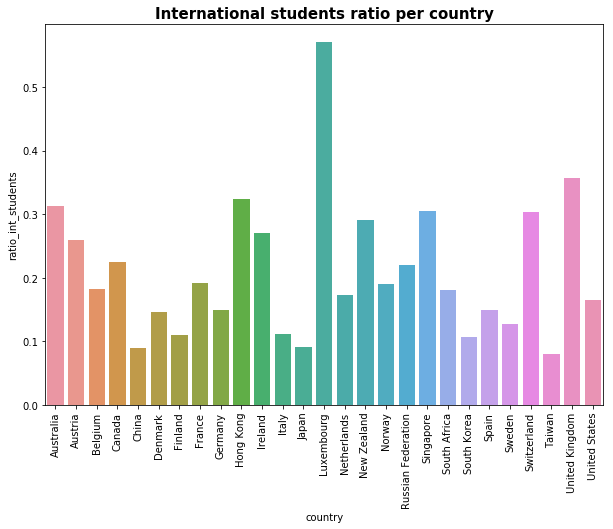

In [23]:
data = ratio_int(times_uni_grouped_country, ['country', 'ratio_int_students'])
custom_bar_plot('country', 'ratio_int_students', data, 'International students ratio per country')

##### Results

Even if the United States is a large and leading country, US universities are devanced by smaller countries like Luxembourg, Hong Kong, Singapore and New Zealand.

#### d) 
##### Explanation

Again we will first sum all the student and international student of a region and then compute the ratio for the same reason as before.

##### 1) ratio between faculty members and students aggregated by region

In [24]:
times_uni_grouped_region = universities_times[['region', 'faculty_tot', 'student_tot', 'student_int']].groupby(['region'], as_index=False).sum()

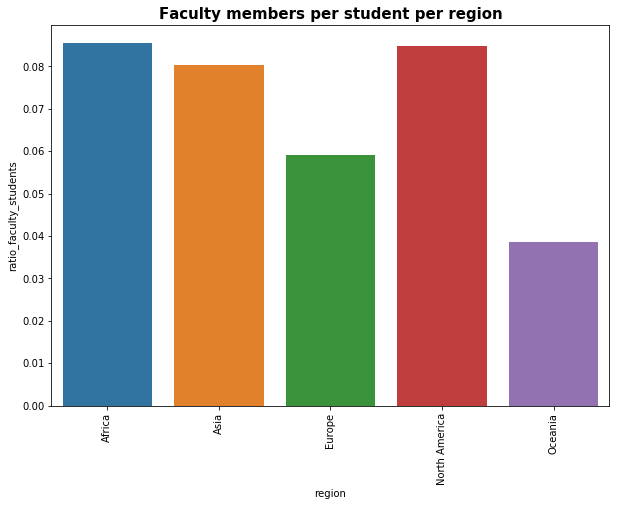

In [25]:
data = ratio_faculty_students(times_uni_grouped_region, ['region', 'ratio_faculty_students'])
custom_bar_plot('region', 'ratio_faculty_students', data, 'Faculty members per student per region')

##### Results

Almost all region have the same ratio of faculty members per students except Oceania which has a ratio twice less than the others.

##### 2) ratio of international students aggregated by region

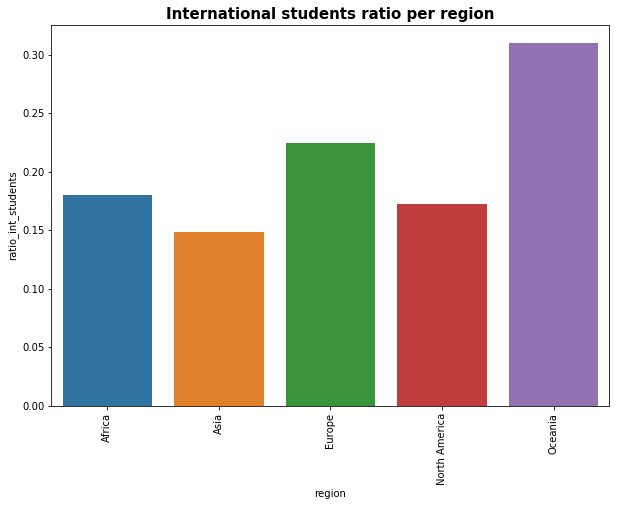

In [26]:
data = ratio_int(times_uni_grouped_region, ['region', 'ratio_int_students'])
custom_bar_plot('region', 'ratio_int_students', data, 'International students ratio per region')

##### Results

Oceania is first with a ratio almost 10% higher than the second. Others regions are more tightly related.

## Task 3

Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

## Solution

### Explanation and assumptions

**Explanation**

In this task, we have to merge the two DataFrames formed in tasks 1 and 2 into a single one, using the universities names to be able to match them accordingly.

To do that, we decided to see which names from one website look like which ones from the other website. One pretty good way to compute how much a string "looks like" another one is to use the Levenshtein distance. The Levenshtein distance gives the number of edits we should do in order to get from one string to the other. For example, the Levenshtein distance of "I like data analysis" and "I love data science" is 10 because we only have to edit 2 characters to go from "like" to "love", and then we have to completely rewrite "analysis" into "science" (7 characters) because nothing is common, and in the end we have to remove the last character of "analysis" because "science" contains 1 character less than "analysis"; so 2 + 7 + 1 = 10.

Once we have the distance between two strings, we can infer a number from 0 to 1 representing how much both strings are similar, 0 being "not similar at all" and 1 being "the same". We just have to take the maximum length of both string and divide it by the distance between both strings, and then we subtract it from 1. This will be our heuristic to evaluate how likely are two universities (from different websites) to match, using their names.

Now that we have something to measure the likelihood of two universities (from different websites) to match, we can iterate over all the ones from the first website and for each one of them, we find the most similar university from the second website (always taking the top 200 only). We can do the same but vice-versa: for each university from the second website, we find the most similar one in the first website. Once we have that, we can compare that both ways of matching "agree" with each other. For example, if 'uniA' from the second website is the most similar one to 'uniZ' from the first website, then it should be the case that 'uniZ' is the most similar one to 'uniA'. If this is indeed the case, we store it as a match.

To compare two universities names, we've removed all leading 'The ', all ',' and all parentheses (with their content) to compare them fairly, as well as all different names for 'university' (in different languages). We've also replaced all 'é' in 'e'. One other thing we also did here is putting a threschold that forces the similarity to be bigger than the threshold in order to be considerer a match. We played a bit with this threshold manually in order to keep only the real match together (we looked at the matchings trying out different thresholds and took a threshold that was allowing to match everything correctly); we've set the threshold to 0.8.

With this technique, the universities that does not appear on both lists will be filtered out (which is what we should do from what we've read on the FAQ), so that's perfect.

In the end, we just have to concatenate the information from the matching universities. We've also added a column ('matching_confidence') representing how confident we were about this match.


**Assumptions**

We don't really have assumptions for this task. We are just using a heuristic to compute the similarity between two universities based on their names, and we are also using a similarity threshold (with value found manually, after inspection of results with different other thresholds) that allows us to match all the universities that we can.

## Code

We define here the different functions used to compare strings, and more specifically universities, as well as the similarity threshold discussed above.

In [27]:
# Import used for regex
import re

# Set up a threschold for defining a 'good enough' match between 2 university names.
# This number has been chosen after trying out others; it seems to be the best fit for here.
SIMILARITY_THRESCHOLD = 0.5

# Keywords for university in different languages
UNIVERSITY_KEYWORDS = ['university', 'université', 'universität', 'universitaet', 'universiteit']

# Compute the Levenshtein distance between 2 strings, which is basically
# how many edits we need in order to go from one string to the other
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    prev = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current = [i + 1]
        for j, c2 in enumerate(s2):
            insert = prev[j + 1] + 1
            delete = current[j] + 1
            substitute = prev[j] + (0 if c1 == c2 else 1)
            current.append(min(insert, delete, substitute))
        prev = current
    
    return prev[-1]

def get_str_similarity(s1, s2):
    longest_str_length = max(len(s1), len(s2))
    similarity = 1.0 - levenshtein_distance(s1, s2) / longest_str_length
    
    return similarity

def get_university_similarity(university1, university2):
    # Remove all parentheses with text inside in the university's names to compare them
    # in a fair way. Also remove all commas in the names, and remove the starting 'The's.
    remove_paren = re.compile(r'\([^)]*\)')
    remove_the = re.compile(r'^the ')
    
    if 'name_top' in university1:
        top_name = university1['name_top'].lower()
        times_name = university2['name_times'].lower()
    else:
        top_name = university2['name_top'].lower()
        times_name = university1['name_times'].lower()
    
    # Remove leading 'The's
    top_name = remove_the.sub('', top_name)
    times_name = remove_the.sub('', times_name)
    
    # Remove all forms of 'University'
    for uni_keyword in UNIVERSITY_KEYWORDS:
        top_name = top_name.replace(uni_keyword, '')
        times_name = times_name.replace(uni_keyword, '')
        
    # Replace all 'é' to 'e'
    top_name = top_name.replace('é', 'e')
    times_name = times_name.replace('é', 'e')
        
    # Remove parentheses + what's inside + ','
    top_name = remove_paren.sub('', top_name).replace(',', '').strip()
    times_name = remove_paren.sub('', times_name).replace(',', '').strip()
    
    # Remove all types of spaces to have only simple spaces between words
    top_name = " ".join(top_name.split())
    times_name = " ".join(times_name.split())
        
    return get_str_similarity(top_name, times_name)

def get_universities_matchings(universities1, universities2):
    matchings = []
    for university1 in universities1.to_dict('records'):
        possibilities = []
        for university2 in universities2.to_dict('records'):
            similarity = get_university_similarity(university1, university2)
            possibilities.append((university2, similarity))

        # Take the best match we can find
        best_match = max(possibilities, key=lambda x: x[1])

        # If the match is 'good enough', add the potential matching
        if best_match[1] > SIMILARITY_THRESCHOLD:
            match = university1
            match.update(best_match[0])
            match.update({CONFIDENCE_COL_NAME: best_match[1]})
            matchings.append(match)
            
    return matchings

Here, we rename all the columns of the previous DataFrames so that we can differentiate them. Then, we find both ways of matching and check which ones agree with each other (those will be our final matchings). Then we create a new DataFrame with the corresponding new columns and the matchings we gathered.

In [28]:
# Set up the column name for the column that will contain the confidence (between 0 and 1)
# of the matching that has be done
CONFIDENCE_COL_NAME = 'matching_confidence'

# Get column names from both DF and change a bit their name (adding '_top' or '_times' as suffix)
universities_top_new = universities_top.add_suffix('_top')
universities_times_new = universities_times.add_suffix('_times')

# Get universities matchings in both ways (find best possible matching for all universities
# in 'universities_top' among the ones in 'universities_times' and vice-versa)
matchings1 = get_universities_matchings(universities_top_new, universities_times_new)
matchings2 = get_universities_matchings(universities_times_new, universities_top_new)

# From those 2 ways matchings, only keep the ones that are consistent with each other
# (best match in one way is also the best match in the other way)
final_matchings = []
for matching1 in matchings1:
    uni_top = matching1['name_top']
    uni_times = matching1['name_times']
    for matching2 in matchings2:
        # Found a match that both ways of matching agree on
        if uni_top == matching2['name_top'] and uni_times == matching2['name_times']:
            final_matchings.append(matching1)

# Concatenate those column names and the confidence column to get the merged column names
merged_column_names = [CONFIDENCE_COL_NAME] + universities_top_new.columns.values.tolist() + universities_times_new.columns.values.tolist()

merged_df = pd.DataFrame(data=final_matchings, columns=merged_column_names)
merged_df

,matching_confidence,name_top,rank_top,country_top,region_top,score_top,faculty_tot_top,faculty_int_top,student_tot_top,student_int_top,...,name_times,rank_times,country_times,region_times,score_times,faculty_tot_times,student_tot_times,student_int_times,fac/stud_times,int/stud_times
0,1.000000,Massachusetts Institute of Technology (MIT),1,United States,North America,100.0,2982.0,1679.0,11067.0,3717.0,...,Massachusetts Institute of Technology,5,United States,North America,92.5,1285,11177,3801,0.114968,0.340073
1,1.000000,Stanford University,2,United States,North America,98.7,4285.0,2042.0,15878.0,3611.0,...,Stanford University,=3,United States,North America,93.0,2113,15845,3486,0.133354,0.220006
2,1.000000,Harvard University,3,United States,North America,98.4,4350.0,1311.0,22429.0,5266.0,...,Harvard University,6,United States,North America,91.8,2284,20326,5285,0.112368,0.260012
3,1.000000,California Institute of Technology (Caltech),4,United States,North America,97.7,953.0,350.0,2255.0,647.0,...,California Institute of Technology,=3,United States,North America,93.0,340,2209,597,0.153916,0.270258
4,1.000000,University of Cambridge,5,United Kingdom,Europe,95.6,5490.0,2278.0,18770.0,6699.0,...,University of Cambridge,2,United Kingdom,Europe,93.2,1688,18389,6437,0.091794,0.350046
5,1.000000,University of Oxford,6,United Kingdom,Europe,95.3,6750.0,2964.0,19720.0,7353.0,...,University of Oxford,1,United Kingdom,Europe,94.3,1823,20409,7756,0.089323,0.380028
6,1.000000,Imperial College London,8,United Kingdom,Europe,93.7,3930.0,2071.0,16090.0,8746.0,...,Imperial College London,8,United Kingdom,Europe,89.2,1391,15857,8722,0.087722,0.550041
7,1.000000,University of Chicago,9,United States,North America,93.5,2449.0,635.0,13557.0,3379.0,...,University of Chicago,9,United States,North America,88.6,2182,13525,3382,0.161331,0.250055
8,0.859649,ETH Zurich - Swiss Federal Institute of Techno...,10,Switzerland,Europe,93.3,2477.0,1886.0,19815.0,7563.0,...,ETH Zurich – Swiss Federal Institute of Techno...,=10,Switzerland,Europe,87.7,1318,19233,7309,0.068528,0.380024
9,1.000000,"Nanyang Technological University, Singapore (NTU)",11,Singapore,Asia,92.2,4338.0,2993.0,25738.0,7251.0,...,"Nanyang Technological University, Singapore",52,Singapore,Asia,70.5,1565,25499,7905,0.061375,0.310012


** Conclusion **

We see that we've found 150 universities that matched, out of 200. So there should be 50 universities on the first website that are not in the second, and vice-versa. This is indeed the case (we checked manually).

## Task 4

Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

## Solution

### Explanation and assumptions

**Explanation**  
We will look at the Pearson correlation coefficient between all dimensions. The coefficient is between -1 and 1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

**Assumptions**  
no assumptions

In [30]:
merged_df.corr()

,matching_confidence,score_top,faculty_tot_top,faculty_int_top,student_tot_top,student_int_top,ratio_faculty_students_top,ratio_int_students_top,score_times,faculty_tot_times,student_tot_times,student_int_times,fac/stud_times,int/stud_times
matching_confidence,1.000000,0.041568,0.122315,0.096977,-0.013950,0.028131,0.139199,0.089574,0.031286,0.111735,-0.032692,-0.015677,0.132878,0.058580
score_top,0.041568,1.000000,0.349568,0.518153,-0.052345,0.194455,0.486797,0.318853,0.815112,0.203978,-0.050566,0.221075,0.243122,0.312547
faculty_tot_top,0.122315,0.349568,1.000000,0.627983,0.582148,0.382167,0.333950,-0.120117,0.363895,0.749098,0.599811,0.355904,0.167605,-0.171872
faculty_int_top,0.096977,0.518153,0.627983,1.000000,0.273879,0.553743,0.308451,0.359011,0.402002,0.280320,0.270959,0.515785,-0.006432,0.299255
student_tot_top,-0.013950,-0.052345,0.582148,0.273879,1.000000,0.631056,-0.437829,-0.214946,0.042549,0.510573,0.982313,0.581459,-0.391561,-0.295481
student_int_top,0.028131,0.194455,0.382167,0.553743,0.631056,1.000000,-0.274881,0.513433,0.176984,0.157612,0.580870,0.922817,-0.370750,0.392541
ratio_faculty_students_top,0.139199,0.486797,0.333950,0.308451,-0.437829,-0.274881,1.000000,0.090865,0.455117,0.180696,-0.423524,-0.268210,0.710964,0.116252
ratio_int_students_top,0.089574,0.318853,-0.120117,0.359011,-0.214946,0.513433,0.090865,1.000000,0.240295,-0.281216,-0.247497,0.519547,-0.088092,0.953089
score_times,0.031286,0.815112,0.363895,0.402002,0.042549,0.176984,0.455117,0.240295,1.000000,0.228867,0.044845,0.210821,0.230006,0.232035
faculty_tot_times,0.111735,0.203978,0.749098,0.280320,0.510573,0.157612,0.180696,-0.281216,0.228867,1.000000,0.540758,0.177160,0.450554,-0.297277


Notice the following:
* The Times ranking does not use most of the features extracted from their website. (low Pearson correlation)

Now we will extract dimensions that are highly correlated. First we find the indices where it is the case then create pair of their dimensions names.

In [31]:
corr_df = merged_df.corr()
indices = np.where(np.abs(corr_df) > 0.5)
indices = [(corr_df.index[x],corr_df.columns[y],"%.2f" % corr_df.iloc[x,y]) for x,y in zip(*indices) if x != y and x < y]
print('Dimensions that are strongly correlated')
indices

Dimensions that are strongly correlated


[('score_top', 'faculty_int_top', '0.52'),
 ('score_top', 'score_times', '0.82'),
 ('faculty_tot_top', 'faculty_int_top', '0.63'),
 ('faculty_tot_top', 'student_tot_top', '0.58'),
 ('faculty_tot_top', 'faculty_tot_times', '0.75'),
 ('faculty_tot_top', 'student_tot_times', '0.60'),
 ('faculty_int_top', 'student_int_top', '0.55'),
 ('faculty_int_top', 'student_int_times', '0.52'),
 ('student_tot_top', 'student_int_top', '0.63'),
 ('student_tot_top', 'faculty_tot_times', '0.51'),
 ('student_tot_top', 'student_tot_times', '0.98'),
 ('student_tot_top', 'student_int_times', '0.58'),
 ('student_int_top', 'ratio_int_students_top', '0.51'),
 ('student_int_top', 'student_tot_times', '0.58'),
 ('student_int_top', 'student_int_times', '0.92'),
 ('ratio_faculty_students_top', 'fac/stud_times', '0.71'),
 ('ratio_int_students_top', 'student_int_times', '0.52'),
 ('ratio_int_students_top', 'int/stud_times', '0.95'),
 ('faculty_tot_times', 'student_tot_times', '0.54'),
 ('student_tot_times', 'student_i

We notice the following insights : 
* when there is a large number of students there is a large number of international students (same for faculty members)
* Top Universities score is highly correlated with the number of international faculty members. This can be explained by the fact that some organizations (like Top Universities) compute the scores using the number of publications and exchanges between faculty members, so a high number of international faculty members emphasizes this exchange. 


In [32]:
corr_df = merged_df.corr()
indices = np.where(np.abs(corr_df) < 0.1)
indices = [(corr_df.index[x],corr_df.columns[y],"%.2f" % corr_df.iloc[x,y]) for x,y in zip(*indices) if x != y and x < y and x != 0 and y != 0]
print('Dimensions that are poorly correlated')
indices

Dimensions that are poorly correlated


[('score_top', 'student_tot_top', '-0.05'),
 ('score_top', 'student_tot_times', '-0.05'),
 ('faculty_int_top', 'fac/stud_times', '-0.01'),
 ('student_tot_top', 'score_times', '0.04'),
 ('ratio_faculty_students_top', 'ratio_int_students_top', '0.09'),
 ('ratio_int_students_top', 'fac/stud_times', '-0.09'),
 ('score_times', 'student_tot_times', '0.04'),
 ('fac/stud_times', 'int/stud_times', '-0.05')]

* There is no correlation between the number of students in an university and the scores.


## Task 5

Can you find the best university taking in consideration both rankings? Explain your approach.

## Solution

### Explanation and assumptions

**Explanation**

In this task, we have to find the "best" university (from information on those two websites). As we've seen before, the websites give a score to the university. If we assume that this score is an overall score, we can then take something like the average of the scores on those websites for each university, and then compare this new score among all universities to find the best one.

We can do something smarter. Indeed, we don't know exactly how both scores were computed, but since they are not the same on each of those websites, they seem to use different ways. It is then possible that it's harder to get a good score on one of those websites than in the other. What we can do is to standardize (subtract by the mean and then divide by the std. dev.) the scores on each websites so that we can fairly average them, and then compare this average among all universities to find the "best" one.

**Assumptions**

As we said, we assume that the values found in the fields 'score' are overall scores for universities. It makes our lifes easier since we only have to look at those in order to determine the "best" university, and it seems to be a reasonable assumption since this is how the universities are sorted on those websites.

## Code

Compute the scores' mean and std dev for both websites:

In [33]:
mean_top = np.mean(universities_top['score'].astype(float))
std_top = np.std(universities_top['score'].astype(float))
print("Scores' mean from '%s' = %.2f" % (TOP_UNIVERSITIES_BASE, mean_top))
print("Scores' std dev from '%s' = %.2f\n" % (TOP_UNIVERSITIES_BASE, std_top))
      
mean_times = np.mean(universities_times['score'].astype(float))
std_times = np.std(universities_times['score'].astype(float))
print("Scores' mean from '%s' = %.2f" % (TIMES_BASE, mean_times))
print("Scores' std dev from '%s' = %.2f" % (TIMES_BASE, std_times))

Scores' mean from 'https://www.topuniversities.com' = 66.31
Scores' std dev from 'https://www.topuniversities.com' = 14.09

Scores' mean from 'https://www.timeshighereducation.com' = 64.52
Scores' std dev from 'https://www.timeshighereducation.com' = 11.09


We see that the std dev of the second website is a bit lower. This means that 'extreme' values in the second website should be worth more than extreme values in the first website. Also, the mean is a bit lower in the second website as well, which means that higher values should also be worth more. This will be the case after the following standardization:

In [34]:
# Disable warning about chained assignment
pd.options.mode.chained_assignment = None # default='warn'

# Simple average of both scores
scores_df = merged_df[['name_top', 'score_top', 'score_times']]
scores_df['score_top'] = scores_df['score_top'].astype(float) 
scores_df['score_times'] = scores_df['score_times'].astype(float)
scores_df['avg_score'] = (scores_df['score_top'] + scores_df['score_times']) / 2

# Standardize the scores with the values found in the top 200 scores from each websites
# and compute the average; this should give a fairer comparison (explained above).
scores_df['score_top_std'] = (scores_df['score_top'] - mean_top) / std_top 
scores_df['score_times_std'] = (scores_df['score_times'] - mean_times) / std_times
scores_df['avg_score_std'] = (scores_df['score_top_std'] + scores_df['score_times_std']) / 2
scores_df = scores_df.sort_values(['avg_score_std'], ascending=False).reset_index(drop=True)
scores_df

,name_top,score_top,score_times,avg_score,score_top_std,score_times_std,avg_score_std
0,Massachusetts Institute of Technology (MIT),100.0,92.5,96.25,2.391514,2.522014,2.456764
1,Stanford University,98.7,93.0,95.85,2.299223,2.567083,2.433153
2,California Institute of Technology (Caltech),97.7,93.0,95.35,2.228230,2.567083,2.397656
3,University of Oxford,95.3,94.3,94.80,2.057846,2.684263,2.371054
4,Harvard University,98.4,91.8,95.10,2.277925,2.458918,2.368421
5,University of Cambridge,95.6,93.2,94.40,2.079144,2.585111,2.332127
6,Imperial College London,93.7,89.2,91.45,1.944257,2.224559,2.084408
7,Princeton University,91.0,91.1,91.05,1.752575,2.395821,2.074198
8,University of Chicago,93.5,88.6,91.05,1.930058,2.170476,2.050267
9,ETH Zurich - Swiss Federal Institute of Techno...,93.3,87.7,90.50,1.915859,2.089352,2.002606


In [35]:
scores_df.head(1)

,name_top,score_top,score_times,avg_score,score_top_std,score_times_std,avg_score_std
0,Massachusetts Institute of Technology (MIT),100.0,92.5,96.25,2.391514,2.522014,2.456764


** Conclusion **

Overall, it seems that the MIT is the best university (by only looking at those two websites).